In [76]:
from glob import glob
import librosa
import matplotlib.pyplot as plt
import random
import numpy as np
from tqdm import tqdm
from pathlib import Path
from tensorflow.keras.utils import Sequence
"""
fnames = glob("../Downloads/birdsong-recognition/train_audio/bkcchi/*mp3") 
fnames += glob("../Downloads/birdsong-recognition/train_audio/amerob/*mp3") 
fnames += glob("../Downloads/birdsong-recognition/train_audio/norcar/*mp3")
fnames += glob("../Downloads/birdsong-recognition/train_audio/horgre/*mp3")"""
fnames = glob("birdsongs/**/*mp3")
random.shuffle(fnames)
!rm spectrograms/*npy
len(fnames)

1372

In [77]:
def make_spectrograms(f):
    w = []
    THRESHOLD = 0.00004
     
    x,sr = librosa.load(f)
    y = librosa.feature.melspectrogram(y=x, n_mels=224,n_fft=4096*2, hop_length=128)
    z =[y[:, i:i+224] for i in range(0, y.shape[1]-224, 64)]
    w.append(np.stack(z))
    w = np.vstack(w)
    w= np.expand_dims(w, -1) # (batch, 224,224,1)

    filtered_w = []
    for img in w:
        if(np.sum(img**2)>THRESHOLD):
            filtered_w.append(img)
    w = np.array(filtered_w)
    for i, ww in enumerate(w):
        fname = f"spectrograms/{Path(f).stem}_{i}"
        arr = (ww - ww.min()) / (ww.max() - ww.min())
        np.save(fname, arr)
 
    return

for f in tqdm(fnames[:700]):
    try:
        make_spectrograms(f)
    except Exception as e:
        print(e)
        


 31%|████████████▉                            | 220/700 [03:51<08:40,  1.08s/it]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!


need at least one array to stack


 49%|████████████████████                     | 343/700 [05:44<04:57,  1.20it/s]Note: Illegal Audio-MPEG-Header 0x65617220 at offset 494848.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
 69%|████████████████████████████▏            | 481/700 [07:54<02:21,  1.55it/s]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!


need at least one array to stack


 75%|██████████████████████████████▊          | 527/700 [08:37<04:52,  1.69s/it]Note: Illegal Audio-MPEG-Header 0x50455441 at offset 2435783.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
 77%|███████████████████████████████▌         | 539/700 [08:49<05:05,  1.90s/it]Note: Illegal Audio-MPEG-Header 0x73206d65 at offset 372736.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
 92%|█████████████████████████████████████▋   | 644/700 [10:40<00:22,  2.52it/s][src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!
100%|█████████████████████████████████████████| 700/700 [11:52<00:00,  1.02s/it]


In [78]:
x  = np.load(glob("spectrograms/*npy")[0])
x.max()

np.float32(1.0)

In [130]:
import numpy as np
from tensorflow.keras.utils import Sequence

class AutoencoderDataGenerator(Sequence):
    def __init__(self, fnames, batch_size, shuffle=True):
        """
        Initialize the data generator.
        
        Args:
            fnames (list): List of file paths to .npy files
            batch_size (int): Number of samples per batch
            shuffle (bool): Whether to shuffle the data after each epoch
        """
        self.fnames = fnames
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(fnames))
        self.on_epoch_end()

    def __len__(self):
        """Return the number of batches per epoch."""
        return int(np.ceil(len(self.fnames) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data."""
        # Get indices for the current batch
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        
        # Get list of filenames for the batch
        batch_fnames = [self.fnames[i] for i in batch_indices]
        
        # Load data
        X = self._load_data(batch_fnames)
        
        # Return (x, x) for autoencoder
        return X, X

    def _load_data(self, batch_fnames):
        """Load and preprocess data from .npy files."""
        # Initialize list to store batch data
        batch_data = []
        
        # Load each .npy file
        for fname in batch_fnames:
            # Load numpy array
            data = np.load(fname)
            batch_data.append(data)
        
        # Stack arrays into a batch (shape: (batch_size, 224, 224, 1))
        batch_data = np.stack(batch_data)
        
        # Optional: Normalize data to [0, 1] if needed
        # batch_data = batch_data / 255.0  # Uncomment if your data needs normalization
        
        return batch_data

    def on_epoch_end(self):
        """Shuffle indices after each epoch if shuffle is True."""
        if self.shuffle:
            np.random.shuffle(self.indices)

data_gen = AutoencoderDataGenerator(glob("spectrograms/*npy"), 32)

In [91]:
x,x = data_gen.__getitem__(0)
x[0].max()

np.float32(1.0)

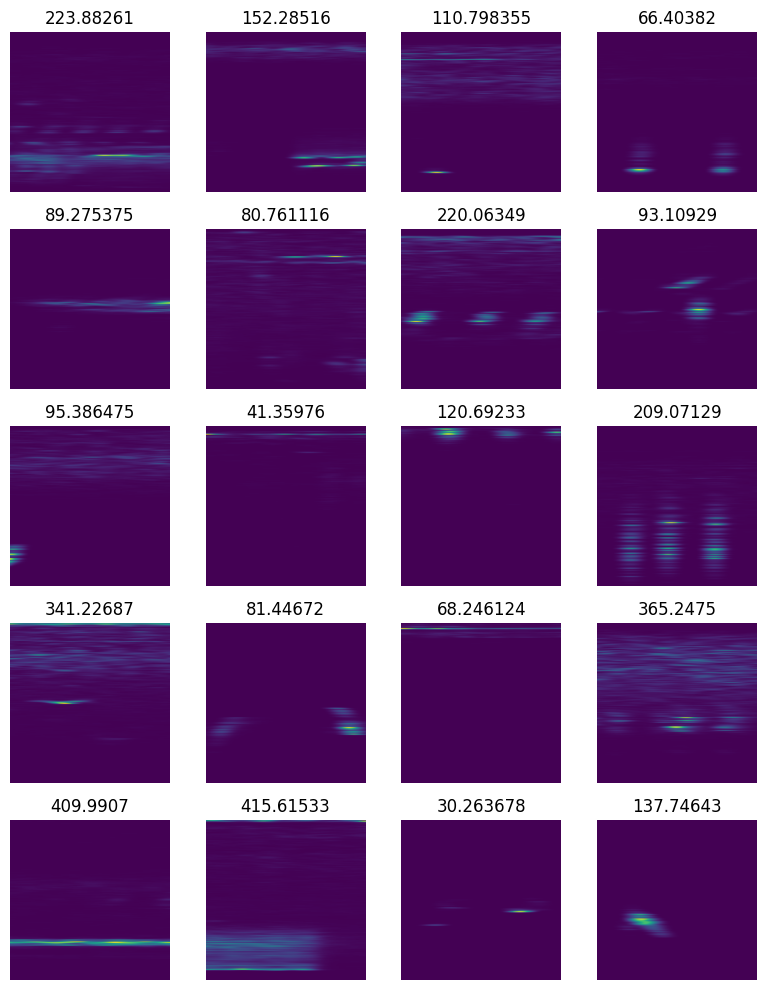

In [86]:

 
images = x[:20,...]
fig, axes = plt.subplots(5, 4, figsize=(8, 10)) # 5 rows, 4 columns, adjust figsize as needed
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

# Iterate through images and display them
for i, img in enumerate(images):
    axes[i].imshow(img, ) # Using grayscale colormap for dummy images
    axes[i].axis('off') # Turn off axes for a clean display
    axes[i].set_title( str(np.sum(img**2)))
# Adjust layout for a tight display
plt.tight_layout()


In [121]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

def build_vq_vae(input_shape=(224, 224, 1), embedding_dim=32, num_embeddings=512):
    """
    Build a Vector Quantized VAE (VQ-VAE) model.
    
    Args:
        input_shape: Input image shape (height, width, channels)
        embedding_dim: Dimensionality of each codebook vector
        num_embeddings: Number of vectors in the codebook
    
    Returns:
        Compiled VQ-VAE model
    """
    
    # Vector Quantization layer
    class VectorQuantizer(layers.Layer):
        def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
            super().__init__(**kwargs)
            self.embedding_dim = embedding_dim
            self.num_embeddings = num_embeddings
            self.beta = beta  # Commitment loss weight
            
            # Initialize codebook
            w_init = tf.random_uniform_initializer()
            self.embeddings = tf.Variable(
                initial_value=w_init(shape=(embedding_dim, num_embeddings), dtype="float32"),
                trainable=True,
                name="embeddings"
            )
            
        def call(self, x):
            # Flatten input for quantization
            input_shape = tf.shape(x)
            flattened = tf.reshape(x, [-1, self.embedding_dim])
            
            # Calculate distances between inputs and codebook vectors
            distances = (tf.reduce_sum(flattened**2, axis=1, keepdims=True) 
                        + tf.reduce_sum(self.embeddings**2, axis=0)
                        - 2 * tf.matmul(flattened, self.embeddings))
            
            # Get closest codebook indices
            encoding_indices = tf.argmin(distances, axis=1)
            encodings = tf.one_hot(encoding_indices, self.num_embeddings)
            
            # Quantize
            quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)
            quantized = tf.reshape(quantized, input_shape)
            
            # Straight-through estimator
            quantized = x + tf.stop_gradient(quantized - x)
            
            # Calculate VQ loss
            commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
            codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
            vq_loss = codebook_loss + self.beta * commitment_loss
            
            # Add loss to layer
            self.add_loss(vq_loss)
            
            return {
                'quantized': quantized,
                'indices': encoding_indices,
                'encodings': encodings,
                'vq_loss': vq_loss,
                'commitment_loss': commitment_loss,
                'codebook_loss': codebook_loss
            }
    
    # Encoder
    encoder_input = keras.Input(shape=input_shape, name='encoder_input')
    
    # Encoder layers
    x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_input)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, 3, activation='relu', strides=2, padding='same')(x)
    
    # Project to embedding dimension
    encoder_output = layers.Conv2D(embedding_dim, 1, padding='same', name='encoder_output')(x)
    
    # Create encoder model
    encoder = keras.Model(encoder_input, encoder_output, name='encoder')
    
    # Vector Quantizer
    vq_layer = VectorQuantizer(num_embeddings, embedding_dim, name='vector_quantizer')
    
    # Decoder
    decoder_input = keras.Input(shape=(14, 14, embedding_dim), name='decoder_input')
    
    # Decoder layers
    x = layers.Conv2DTranspose(256, 3, activation='relu', strides=2, padding='same')(decoder_input)

    x = layers.Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
    
    # Output layer
    decoder_output = layers.Conv2D(input_shape[-1], 3, activation='sigmoid', padding='same', name='decoder_output')(x)
    
    # Create decoder model
    decoder = keras.Model(decoder_input, decoder_output, name='decoder')
    
    # VQ-VAE model
    class VQVAE(keras.Model):
        def __init__(self, encoder, decoder, vq_layer, **kwargs):
            super(VQVAE, self).__init__(**kwargs)
            self.encoder = encoder
            self.decoder = decoder
            self.vq_layer = vq_layer
            
        def call(self, inputs):
            encoded = self.encoder(inputs)
            vq_output = self.vq_layer(encoded)
            decoded = self.decoder(vq_output['quantized'])
            return decoded
            
        def encode(self, inputs):
            """Encode inputs and return codebook indices"""
            encoded = self.encoder(inputs)
            vq_output = self.vq_layer(encoded)
            return vq_output['indices']
            
        def decode_from_indices(self, indices, spatial_shape=(14, 14)):
            """Decode from codebook indices"""
            # Convert indices to one-hot encodings
            encodings = tf.one_hot(indices, self.vq_layer.num_embeddings)
            
            # Get quantized vectors
            quantized = tf.matmul(encodings, self.vq_layer.embeddings, transpose_b=True)
            
            # Reshape to spatial dimensions
            batch_size = tf.shape(indices)[0]
            quantized = tf.reshape(quantized, [batch_size, spatial_shape[0], spatial_shape[1], -1])
            
            # Decode
            return self.decoder(quantized)
            
        def get_codebook(self):
            """Return the codebook vectors"""
            return self.vq_layer.embeddings
            
        def train_step(self, data):
            if isinstance(data, tuple):
                data = data[0]
                
            with tf.GradientTape() as tape:
                # Forward pass
                encoded = self.encoder(data)
                vq_output = self.vq_layer(encoded)
                decoded = self.decoder(vq_output['quantized'])
                
                # Reconstruction loss
                reconstruction_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(data, decoded)
                ) ###   ChatGPT o3 suggested removing this factor -> * np.prod(input_shape)
                
                # VQ loss is automatically added by the VQ layer
                vq_loss = sum(self.vq_layer.losses)
                
                # Total loss
                total_loss = reconstruction_loss + vq_loss
                
            # Compute gradients and update weights
            grads = tape.gradient(total_loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            
            # Update metrics
            self.compiled_metrics.update_state(data, decoded)
            
            return {
                'loss': total_loss,
                'reconstruction_loss': reconstruction_loss,
                'vq_loss': vq_loss,
                'commitment_loss': vq_output['commitment_loss'],
                'codebook_loss': vq_output['codebook_loss']
            }
    
    # Create and return VQ-VAE model
    vq_vae = VQVAE(encoder, decoder, vq_layer)
    
    return vq_vae

# Example usage:
if __name__ == "__main__":
    # Build the model
    model = build_vq_vae(input_shape=(224, 224, 1), embedding_dim=32, num_embeddings=512)
    
    # Compile the model
    adam = keras.optimizers.Adam(learning_rate=0.0001, clipnorm =1.0)
    es = keras.callbacks.EarlyStopping(monitor='reconstruction_loss',mode='min', patience=3)
    model.compile(optimizer=adam,)
    
    # Print model info
    print("VQ-VAE Model built successfully!")
    print(f"Input shape: (224, 224, 1)")
    print(f"Embedding dimension: 32")
    print(f"Codebook size: 512 vectors")
    
    # Example of how to use the model:
    # 1. Train the model
    # model.fit(x_train, x_train, epochs=50, batch_size=32)
    
    # 2. Get codebook indices for images
    # indices = model.encode(x_test)  # Returns discrete codebook indices
    
    # 3. Reconstruct from indices
    # reconstructed = model.decode_from_indices(indices)
    
    # 4. Get the learned codebook
    # codebook = model.get_codebook()  # Shape: (32, 512)

VQ-VAE Model built successfully!
Input shape: (224, 224, 1)
Embedding dimension: 32
Codebook size: 512 vectors


In [122]:
history = model.fit(data_gen, epochs=15, callbacks=[es] )

Epoch 1/15


/home/gary/miniconda3/envs/tf_gpu/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py:646: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


660/843 ━━━━━━━━━━━━━━━━━━━━ 33s 183ms/step - codebook_loss: 190384784.0000 - commitment_loss: 190384784.0000 - loss: 237980976.0000 - reconstruction_loss: 0.1521 - vq_loss: 237980976.0000

KeyboardInterrupt: 

In [120]:
x, x = data_gen.__getitem__(2)
x = np.expand_dims(x[9], 0)
np.reshape(model.encode(x).numpy(), (14,14))
#plt.figure()
#plt.imshow(z[0])


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
x = np.random.random((200,200))
plt.subplot(121)
plt.imshow(x)
plt.subplot(122)
plt.imshow(x)

# Second try from o3

In [132]:
"""
VQ-VAE for 224×224×1 spectrograms
=================================
Stable training with:
  * EMA Vector-Quantiser
  * MSE reconstruction loss
  * Gradient-norm clipping
"""

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
try:
    import tensorflow_addons as tfa          # for GroupNorm
    GroupNorm = lambda: tfa.layers.GroupNormalization(groups=8)
except ImportError:
    GroupNorm = lambda: layers.BatchNormalization()

# --------------------------------------------------------------------- #
# 1.  Vector-Quantiser, EMA version (no trainable parameters)
# --------------------------------------------------------------------- #
class VectorQuantizerEMA(layers.Layer):
    def __init__(self,
                 num_embeddings: int,
                 embedding_dim : int,
                 commitment_cost: float = 0.25,
                 decay: float = 0.99,
                 epsilon: float = 1e-5,
                 **kwargs):
        super().__init__(**kwargs)
        self.num_embeddings  = num_embeddings
        self.embedding_dim   = embedding_dim
        self.commitment_cost = commitment_cost
        self.decay           = decay
        self.epsilon         = epsilon

    def build(self, input_shape):
        # Code-book
        init = tf.random.uniform([self.num_embeddings, self.embedding_dim],
                                 minval=-1., maxval=1.)
        self.embeddings      = tf.Variable(init, trainable=False,
                                           name='embeddings')
        # EMA helpers
        self.ema_cluster_size = tf.Variable(tf.zeros([self.num_embeddings]),
                                            trainable=False)
        self.ema_embed = tf.Variable(init, trainable=False)

    def call(self, inputs, training=None):
        # inputs: [B, H, W, D]
        input_shape = tf.shape(inputs)
        flat_inputs = tf.reshape(inputs, [-1, self.embedding_dim])   # [BHW,D]

        # Squared Euclidean distance to every embedding
        distances = (tf.reduce_sum(flat_inputs**2, 1, keepdims=True)
                     - 2 * tf.matmul(flat_inputs, self.embeddings, transpose_b=True)
                     + tf.reduce_sum(self.embeddings**2, 1))

        encoding_indices = tf.argmin(distances, axis=1)              # [BHW]
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)  # [BHW,K]

        # Quantise and reshape back to image
        quantised = tf.matmul(encodings, self.embeddings)            # [BHW,D]
        quantised = tf.reshape(quantised, input_shape)

        # ------------------------------------------------------------------
        # EMA update of code-book (executed only in training mode)
        # ------------------------------------------------------------------
        if training:
            updated_cluster_size = tf.reduce_sum(encodings, axis=0)          # [K]
            dw = tf.matmul(encodings, flat_inputs, transpose_a=True)         # [K,D]

            self.ema_cluster_size.assign(self.decay * self.ema_cluster_size +
                                         (1. - self.decay) * updated_cluster_size)
            self.ema_embed.assign(self.decay * self.ema_embed +
                                  (1. - self.decay) * dw)

            n = tf.reduce_sum(self.ema_cluster_size)            # total elements
            cluster_size = ((self.ema_cluster_size + self.epsilon) /
                            (n + self.num_embeddings * self.epsilon)) * n
            normalized_embed = self.ema_embed / tf.expand_dims(cluster_size, 1)
            self.embeddings.assign(normalized_embed)

        # ------------------------------------------------------------------
        # Losses
        # ------------------------------------------------------------------
        commitment_loss = tf.reduce_mean(
            tf.square(tf.stop_gradient(quantised) - inputs))
        self.add_loss(self.commitment_cost * commitment_loss)

        # Straight-through estimator
        quantised = inputs + tf.stop_gradient(quantised - inputs)
        return quantised, tf.reshape(encoding_indices, input_shape[:3])  # indices for later use


# --------------------------------------------------------------------- #
# 2.  Encoder / Decoder building blocks
# --------------------------------------------------------------------- #
def enc_block(x, filters, stride=2):
    x = layers.Conv2D(filters, 4, strides=stride,
                      padding='same', use_bias=False)(x)
    x = GroupNorm()(x)
    return layers.LeakyReLU(0.2)(x)

def dec_block(x, filters):
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(filters, 3, padding='same', use_bias=False)(x)
    x = GroupNorm()(x)
    return layers.LeakyReLU(0.2)(x)


# --------------------------------------------------------------------- #
# 3.  Complete VQ-VAE model
# --------------------------------------------------------------------- #
def build_vqvae(input_shape=(224, 224, 1),
                embedding_dim=32,
                num_embeddings=512,
                beta=0.25):
    # ---------------- Encoder ---------------- #
    encoder_in  = keras.Input(shape=input_shape)
    x = enc_block(encoder_in,  32)    # 112×112
    x = enc_block(x,  64)             # 56×56
    x = enc_block(x, 128)             # 28×28
    x = enc_block(x, 256)             # 14×14
    x = layers.Conv2D(embedding_dim, 1, padding='same',
                      use_bias=False)(x)          # (14,14,32)
    encoder_out = x
    encoder = keras.Model(encoder_in, encoder_out, name='encoder')

    # -------------- Vector-Quantiser ---------- #
    vq_layer = VectorQuantizerEMA(num_embeddings,
                                  embedding_dim,
                                  commitment_cost=beta,
                                  name='vector_quantiser')

    # --------------- Decoder ------------------ #
    quant_in = keras.Input(shape=(14, 14, embedding_dim))
    y = dec_block(quant_in, 256)      # 28×28
    y = dec_block(y, 128)             # 56×56
    y = dec_block(y,  64)             # 112×112
    y = dec_block(y,  32)             # 224×224
    logits = layers.Conv2D(1, 3, padding='same')(y)   # raw logits
    decoder_out = layers.Activation('sigmoid')(logits)
    decoder = keras.Model(quant_in, decoder_out, name='decoder')

    # ------------- End-to-end Model ----------- #
    inputs = keras.Input(shape=input_shape)
    z_e = encoder(inputs)
    z_q, indices = vq_layer(z_e)
    recon = decoder(z_q)

    # ------------- End-to-end subclassed model -------------------- #
    class VQVAE(keras.Model):
        def __init__(self, encoder, vq_layer, decoder, **kwargs):
            super().__init__(**kwargs)
            self.encoder  = encoder
            self.vq_layer = vq_layer
            self.decoder  = decoder

            self.total_loss_tracker = keras.metrics.Mean(name='total_loss')
            self.recon_loss_tracker = keras.metrics.Mean(name='recon_loss')
            self.vq_loss_tracker    = keras.metrics.Mean(name='vq_loss')

        # forward pass
        def call(self, x, training=False):
            z_e = self.encoder(x, training=training)
            z_q, _ = self.vq_layer(z_e, training=training)
            return self.decoder(z_q, training=training)

        # custom training loop
        def train_step(self, data):
            if isinstance(data, tuple):
                data = data[0]
            with tf.GradientTape() as tape:
                recon   = self(data, training=True)
                r_loss  = tf.reduce_mean(tf.square(data - recon))
                vq_loss = tf.add_n(self.vq_layer.losses)       # commitment term
                t_loss  = r_loss + vq_loss

            grads = tape.gradient(t_loss, self.trainable_variables)
            grads = [tf.clip_by_norm(g, 1.0) if g is not None else None
                     for g in grads]
            self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

            self.total_loss_tracker.update_state(t_loss)
            self.recon_loss_tracker.update_state(r_loss)
            self.vq_loss_tracker.update_state(vq_loss)
            return {'loss':        self.total_loss_tracker.result(),
                    'recon_loss':  self.recon_loss_tracker.result(),
                    'vq_loss':     self.vq_loss_tracker.result()}

        # (encode / decode helpers exactly as before)
        def encode(self, x):
            z_e = self.encoder(x, training=False)
            _, idx = self.vq_layer(z_e, training=False)
            return idx                        # shape (B,14,14)

        def decode_from_indices(self, indices):
            one_hot = tf.one_hot(indices, depth=num_embeddings)      # [B,14,14,K]
            flat    = tf.reshape(one_hot, [-1, num_embeddings])
            z_q = tf.matmul(flat, self.vq_layer.embeddings)          # [B*14*14,D]
            z_q = tf.reshape(z_q, [-1, 14, 14, embedding_dim])
            return self.decoder(z_q, training=False)

        def get_perplexity(self):
            """lower beta if perplexity is less than 10% (using few codes)"""
            probs = self.ema_cluster_size / tf.reduce_sum(self.ema_cluster_size)
            return tf.exp(-tf.reduce_sum(probs * tf.math.log(probs + 1e-10)))

    # create and return the model (NO positional tensors)
    return VQVAE(encoder, vq_layer, decoder, name='VQ_VAE')

# --------------------------------------------------------------------- #
# 4.  Build, compile, train
# --------------------------------------------------------------------- #
if __name__ == '__main__':
    # -------- data pipeline ------------------------------------------------
    # `data_gen` must yield float32 tensors in [0,1] of shape (224,224,1)
    BATCH  = 64
    STEPS  = 100_000 // BATCH          # one epoch = entire data set
    EPOCHS = 100

    ds = (tf.data.Dataset.from_generator(lambda: data_gen,
            output_signature=tf.TensorSpec(shape=(224, 224, 1),
                                           dtype=tf.float32))
          .shuffle(1000)
          .batch(BATCH)
          .prefetch(tf.data.AUTOTUNE))

    # -------- build & compile ---------------------------------------------
    model = build_vqvae(input_shape=(224,224,1),
                        embedding_dim=32,
                        num_embeddings=512,
                        beta=0.25)

    model.compile(optimizer=keras.optimizers.Adam(3e-4, clipnorm=1.0))

    # -------- training -----------------------------------------------------
    # Early-stopping on reconstruction loss usually works well
    es = keras.callbacks.EarlyStopping(patience=10,
                                       monitor='recon_loss', mode='min',
                                       restore_best_weights=True)

    model.fit(data_gen, epochs=EPOCHS, steps_per_epoch=STEPS, callbacks=[es])

    # You now have a stable VQ-VAE with a 512-vector code-book.

Epoch 1/100
 658/1562 ━━━━━━━━━━━━━━━━━━━━ 1:08 76ms/step - loss: 0.0528 - recon_loss: 0.0396 - vq_loss: 0.0132

2025-07-06 15:18:36.745933: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.3 = (f32[29,1,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[29,32,224,224]{3,2,1,0} %bitcast.15792, f32[1,32,3,3]{3,2,1,0} %bitcast.11440, f32[1]{0} %bitcast.15927), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="VQ_VAE_1/decoder_1/conv2d_89_1/convolution" source_file="/home/gary/miniconda3/envs/tf_gpu/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 141s 83ms/step - loss: 0.0291 - recon_loss: 0.0220 - vq_loss: 0.0072
Epoch 2/100
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 119s 76ms/step - loss: 0.0011 - recon_loss: 8.6133e-04 - vq_loss: 2.1517e-04
Epoch 3/100
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 8.9097e-04 - recon_loss: 6.5760e-04 - vq_loss: 2.3337e-04 
Epoch 4/100


/home/gary/miniconda3/envs/tf_gpu/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 121s 77ms/step - loss: 8.8653e-04 - recon_loss: 6.3069e-04 - vq_loss: 2.5584e-04
Epoch 5/100
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 120s 77ms/step - loss: 8.1664e-04 - recon_loss: 5.5528e-04 - vq_loss: 2.6137e-04
Epoch 6/100
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 7.7153e-04 - recon_loss: 5.1749e-04 - vq_loss: 2.5404e-04 
Epoch 7/100
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 121s 77ms/step - loss: 7.4580e-04 - recon_loss: 4.9057e-04 - vq_loss: 2.5524e-04
Epoch 8/100
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 121s 77ms/step - loss: 7.1958e-04 - recon_loss: 4.6567e-04 - vq_loss: 2.5391e-04
Epoch 9/100
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 6.8442e-04 - recon_loss: 4.4018e-04 - vq_loss: 2.4424e-04 
Epoch 10/100
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 122s 78ms/step - loss: 6.6023e-04 - recon_loss: 4.2225e-04 - vq_loss: 2.3798e-04
Epoch 11/100
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 122s 78ms/step - loss: 6.4605e-04 - recon_loss: 4.0390e-04 - vq_loss: 2.4215e-04
Epoch 12/100
1562/

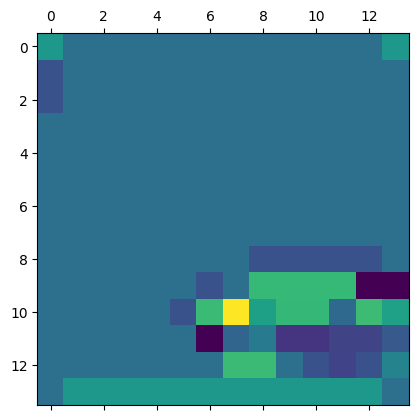

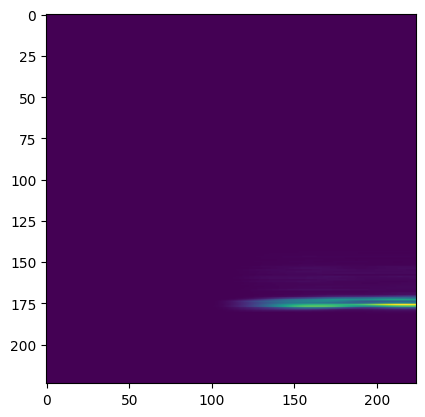

In [182]:
n=10
y = model.encode(np.expand_dims(x[n],0))
plt.matshow(y[0])
plt.figure()
plt.imshow(x[n])

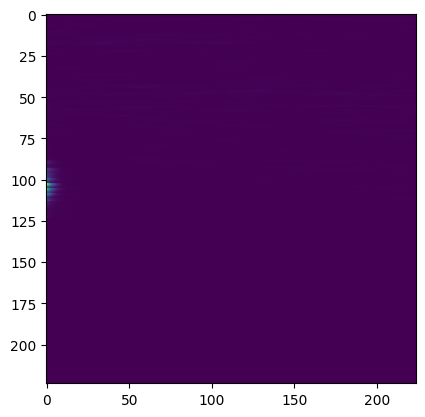

In [141]:
x,x = data_gen.__getitem__(20)
x.shape

(32, 224, 224, 1)

In [188]:
probs = model.vq_layer.ema_cluster_size / tf.reduce_sum(model.vq_layer.ema_cluster_size)
tf.exp(-tf.reduce_sum(probs * tf.math.log(probs + 1e-10))).numpy()

np.float32(35.95868)